# Simple Neural Network Train on MNIST digits

We will create the simplest image-classifying neural network using Tensorflow to recognize 28x28 pixel grayscale images of hand drawn numerical digits (i.e. the MNIST data set).

The neural network we build will have:
* an input layer
* a single hidden layer
* an output layer

Our simple network will ingest each digit as a flattened 784-number vector and hence the input layer is 784 units wide. We will use a fully connected 'hidden layer' arbitrarily sized at 1024 units wide. The output layer will be 10 units wide assuming the one-hot method of encoding the categorization i.e. the zeroeth unit output represents the recognition of digit "zero" .. the tenth as digit "nine".

I.e. in summary the nework is fully connected with layers of 784 -> 1024 -> 10.

## import MNIST TRAINING 28x28 digits
CSV file each row is <category><pixels 0..783>
    
Here we set up the imports and define the data import routine.

The MNIST training data set contains 60000 images, each with their 0..9 classification.

Each MNIST digit is a 28x28 grayscale image, flattened into a single 784-element row of the CSV file, with each element being between 0.0 and 1.0 being the grayscale of that pixel.

Each row of the training data also has an *additional* first element 0..9 representing the 'correct answer' (we will call it the digits *label*) for the corresponding image in the rest of the row. E.g. a row containing an image for the number "5" will be
```5,<image pixel data>``` where as described above the pixel data is 784 numbers between 0.0 and 1.0.

Hence the MNIST training data set is a 60000x785 CSV file of 60,000 rows (i.e. 60,000 images), each of 785 numbers.

For our purposes we will strip the images and labels into separate matrices, and also we will convert each label into its one-hot representation, e.g. "5" becomes "0,0,0,0,0,1,0,0,0,0"

In [39]:
DATA_DIR = '../../Data/mnist/' # Contains the mnist_train.csv file

In [40]:
import math
import random
import numpy as np
import time

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf

def load_mnist():
    print('Loading MNIST training data...')
    file_data = np.loadtxt(DATA_DIR+'mnist_train.csv', delimiter = ',')
    print('Loaded MNIST training data, shape {0} dtype {1}'.format(file_data.shape, file_data.dtype))
    # extract first element (label) from each row of the data, and convert to one-hot 0..9
    labels = file_data[:,0].astype(int) # 1st element of each row is label
    one_hot_labels = np.zeros((labels.size, 10)) # initialize same length array with 10-element zero vectors
    one_hot_labels[np.arange(labels.size),labels] = 1 # set the n'th element of one-hot vector to 1 (n=label)
    # extract the digit pixels
    digits = file_data[:,1:] # remaining elements are 784-pixel vectors
    digits -= digits.min() # scale the data so values are between 0 and 1
    digits /= digits.max() # scale
    
    return (one_hot_labels, digits)

### Call load_mnist() to import the actual MNIST data from the Data/mnist_train.csv file
Note this can take ~30 seconds, when complete you should see all 3 messages
```
Loading MNIST training data...
Loaded MNIST training data, shape (60000, 785) dtype float64
data_labels.shape (60000, 10)
data_digits.shape (60000, 784)
```

In [41]:
(data_labels,data_digits) = load_mnist()

print('data_labels.shape {0}'.format(data_labels.shape))
print('data_digits.shape {0}'.format(data_digits.shape))


Loading MNIST training data...
Loaded MNIST training data, shape (60000, 785) dtype float64
data_labels.shape (60000, 10)
data_digits.shape (60000, 784)


### Inspect the first digit

First we need to write a utility function to display a digit. We'll use matplotlib.

In [42]:
def print_digit(digit):
    test_digit = np.mat(digit).reshape(28,28)
    plt.imshow(test_digit, cmap='gray')
    plt.show()
    

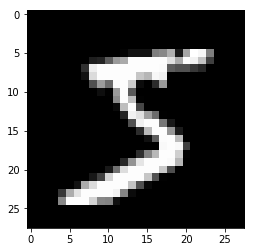

In [43]:
print_digit(data_digits[0])

In [44]:
data_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

## use Tensorflow to classify the images

First we'll create a trivial 'hello world' tensorflow session just to see things working, this is nothing to do with actually recognizing the images...

In [45]:

sess = tf.InteractiveSession()

x1 = tf.constant([1,2,3,4])
x2 = tf.constant([5,6,7,8])
result = tf.multiply(x1,x2)
print(sess.run(result))
sess.close()

[ 5 12 21 32]


Let's just confirm our 60000x784 'data_digits' archive has the pixels calibrated 0.0..1.0 as we expect:

In [46]:
print('pixel data range {0}..{1}'.format(data_digits.min(),data_digits.max()))

pixel data range 0.0..1.0


### Define some constants.
These include our network *hyper-parameters* i.e. the arbitarily chosen dimensions that seem to work for our problem

In [47]:
# Just our data spec
IMAGE_SIZE_X = 28
IMAGE_SIZE_Y = 28
IMAGE_SIZE = IMAGE_SIZE_X * IMAGE_SIZE_Y

# NN Hyper-parameters
INPUT_SIZE = IMAGE_SIZE
LABELS_SIZE = 10
HIDDEN_SIZE = 1024
GRADIENT_DESCENT_STEP_SIZE = 1e-4 # aka 0.0001

## Woot, here we define the actual Neural Network
Note that in tensorflow each layer is declared as a 'lazy' function for future evaluation (see __[Eduonix tensorflow tutorial](https://www.youtube.com/watch?v=dmBgC-pEBIg&list=PLDmvslp_VR0z38Mpr8G3-5ob-GynDC2pH)__)

So here we're just setting up the data flow, not executing the training algorithm.

In [48]:
layer_input = tf.placeholder(tf.float32, [None, INPUT_SIZE])
layer_hidden = tf.layers.dense(inputs=layer_input, units=HIDDEN_SIZE, activation=tf.nn.relu)
layer_output = tf.layers.dense(inputs=layer_hidden, units=LABELS_SIZE)

In addition we'll define a tensorflow structure to hold the 'correct answer', i.e. the labels provided in the training data set.

In [49]:
layer_labels = tf.placeholder(tf.float32, [None, LABELS_SIZE])

Here we define the 'loss' (aka 'error') function, ultimately to provide a scalar value representing the error between the guessed label and the 'correct' label. E.g. given a guess at the number "5":
```
layer_labels [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] # correct answer
layer_output [0.1, 0.0, 0.2, 0.0, 0.1, 0.7, 0.1, 0.2, 0.0, 0.1] # guess
->
0.35
```
Keep in mind there's an important subtlety here, where the tensorflow functions are designed to ingest entire *tensors*, so actually the loss function can ultimately be computed as a matrix operation on the entire 60000x784, 60000x10, 60000x10 input, output and label tensors respectively. Nevertheless IMHO there's value in mentally keeping track of this process in terms of an image at a time.

Hopefully it now makes sense that the loss function works on the difference between the `layer_labels` and the the `layer_output` i.e. the "correct answer" and the "guessed answer".

In [50]:
loss = tf.losses.softmax_cross_entropy(layer_labels, layer_output)

Given the network defined above, we can now define the **backpropagation** training function.  This is the particular benefit of using tensorflow: each of the earlier layer definition functions has a pre-defined differential that can be used in a typical 'gradient descent'-type error minimisation algorithm.

For our purposes we'll use the tensorflow-provided `AdamOptimizer()`, and you'll see we necessarily tell it the function to use (i.e. our `loss()` function) giving the error value that is to be minimized.

In [51]:
train_step = tf.train.AdamOptimizer(GRADIENT_DESCENT_STEP_SIZE).minimize(loss)

As kind of an inverse consideration to the 0.0..1.0 `loss` function, we'll create an `accuracy` value which is what proportion of the time did the network get the guess 'right'. For these functions it is helpful to think of them given the entire 60000-row input tensor. 

The `correct_prediction` contains True where the `output` (aka guess) strongest suggestion matches the training label correct answer, e.g.
```
layer_labels [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] # correct answer
layer_output [0.1, 0.0, 0.2, 0.0, 0.1, 0.7, 0.1, 0.2, 0.0, 0.1] # guess
->
True
```

In [52]:
correct_prediction = tf.equal(tf.argmax(layer_output, 1), tf.argmax(layer_labels, 1))

Our `accuracy` function uses tf.cast to convert each `correct_prediction` True and False to 1.0 and 0.0 respectively, and then find the arithmetic mean of the entire list. The average of the ones and zeroes is exactly the same as the proportion of ones (think about it).

In [53]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Finally, here's where we run the training model

Actually we run through the training data in 'steps', so for each step we can output an accuracy value. E.g. for the first step we could pass the first 1000 images through the network (0..999), output an accuracy value, then use images 1000..1999, then 2000..2999 etc. On each step we should see the accuracy improve.

In [54]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

STEP_SIZE = 12345
STEPS_COUNT = 10
(DATA_COUNT,_) = data_digits.shape

step_cursor = 0

# record start time
START_TIME = time.process_time()

# create lists to hold time, accuracy tuples
graph_data_time = []
graph_data_accuracy = []

for i in range(STEPS_COUNT):
    # update cursor to select current 'step' of training data
    step_cursor += STEP_SIZE # index into data_digits and data_labels for current step
    step_limit = step_cursor + STEP_SIZE # limit index for end of batch
    if step_limit > DATA_COUNT:
        step_cursor = step_limit - DATA_COUNT # wrap around to start of data
        step_limit = STEP_SIZE
    
    # create input digits step_digits and asociated labels step_labels
    step_digits = data_digits[step_cursor:step_limit]
    step_labels = data_labels[step_cursor:step_limit]

    # create tensorflow 'feed dictionary' that maps inputs to tensorflow tensors
    feed_dict={layer_input: step_digits, layer_labels: step_labels}
    
    # do training run for this step
    train_step.run(feed_dict=feed_dict)
    
    # calculate accuracy
    train_accuracy = accuracy.eval(feed_dict=feed_dict)
    
    # note process time for this step in ns
    execution_time_ns = time.process_time() - START_TIME
    
    graph_data_time.append(execution_time_ns)
    graph_data_accuracy.append(train_accuracy)
    
    print('step {0:3d} digits {1:5d}..{2:5d} accuracy {3:.3f}'.format(i,step_cursor, step_limit, train_accuracy))
    
sess.close()


step   0 digits 12345..24690 accuracy 0.162
step   1 digits 24690..37035 accuracy 0.189
step   2 digits 37035..49380 accuracy 0.224
step   3 digits  1725..12345 accuracy 0.275
step   4 digits 14070..26415 accuracy 0.329
step   5 digits 26415..38760 accuracy 0.380
step   6 digits 38760..51105 accuracy 0.454
step   7 digits  3450..12345 accuracy 0.524
step   8 digits 15795..28140 accuracy 0.564
step   9 digits 28140..40485 accuracy 0.589


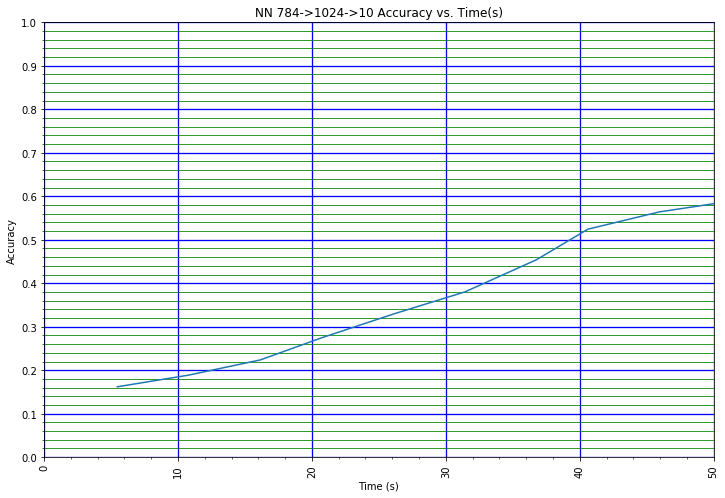

In [55]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("NN 784->1024->10 Accuracy vs. Time(s)", fontsize='large')

## Set up Time x axis

ax.set_xlabel("Time (s)")
# Min x axis value is 0 (so y-axis crosses at x=0)
ax.set_xlim(left=0)
# x ticks at 10s
ax.set_xticks(np.arange(0.0,max(graph_data_time),10))
ax.xaxis.grid(which='major', color='b', linewidth=1.3)

## Set up Accuracy y axis

ax.set_ylabel("Accuracy")
ax.set_ylim(bottom=0)
# Set Accuracy tick locations and define horizontal grid lines
minorLocator = MultipleLocator(0.05)
majorLocator = MultipleLocator(0.1)
ax.yaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.grid(which='major', color='b', linewidth=1.3)
ax.yaxis.grid(which='minor', color='g')

# Plot the chart
ax.plot(graph_data_time, graph_data_accuracy)

plt.minorticks_on()
plt.xticks(rotation=90)
plt.show(fig)